In [2]:
import numpy as np
import anndata as ad
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import anndata
import seaborn as sns
import matplotlib.colors as mcolors
from scipy.stats import zscore
import scvelo as scv
import bbknn

In [87]:
adata = l23_PC1_shifted
adata.X = np.nan_to_num(adata.X)
genesets = new_genesets
slice_categories = ['NR1_2', 'NR2_2', 'DR1_2', 'DR2_2']
n_rows, n_cols = len(genesets), len(slice_categories)

# 创建绘图布局
fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 2.5 * n_rows))

for row_idx, (geneset_name, geneset) in enumerate(genesets.items()):
    if not geneset:
        for ax in axs[row_idx, :]:
            ax.axis("off")
        continue

    slice_g_values = {}
    slice_gmin_gmax = {}
    slice_vmin_vmax = {}
    vmax_vmin_diffs = {}

    # Step 1: 计算每个 slice 的 vmin, vmax 和 g_min, g_max
    for slice_category in slice_categories:
        slice_data = adata[adata.obs['slice'] == slice_category]
        if slice_data.n_obs > 0:
            g = slice_data[:, geneset].X.mean(axis=1).flatten()
            vmin, vmax = np.percentile(g, 5), np.percentile(g, 95)  # vmin 和 vmax 为数据的最小值和最大值
            g_clipped = np.clip(g, vmin, vmax)  # 将数据限制在 vmin 和 vmax 范围内
            g_min, g_max = np.min(g_clipped), np.max(g_clipped)
            g_norm = (g_clipped - g_min) / (g_max - g_min)  # 归一化到 [0, 1]
            slice_g_values[slice_category] = (g_norm, slice_data.obsm['stereo_rotated'][:, 0], slice_data.obsm['stereo_rotated'][:, 1])
            slice_gmin_gmax[slice_category] = (g_min, g_max)
            slice_vmin_vmax[slice_category] = (vmin, vmax)
            vmax_vmin_diffs[slice_category] = vmax - vmin

    # Step 2: 选择基准 slice（vmax - vmin 最大的 slice）
    base_slice = max(vmax_vmin_diffs, key=vmax_vmin_diffs.get)
    base_gmin, base_gmax = slice_gmin_gmax[base_slice]  # 基准 slice 的 g_min 和 g_max

    # Step 3: 调整其他 slice 的 g 值
    adjusted_g_values = {}
    for slice_category in slice_categories:
        g_norm, x, y = slice_g_values.get(slice_category, (None, None, None))
        g_min, g_max = slice_gmin_gmax.get(slice_category, (None, None))
        if g_norm is not None:
            # 缩放公式
            g_adjusted = 0.5 + (g_norm - 0.5) * (g_max - g_min) / (base_gmax - base_gmin)
            adjusted_g_values[slice_category] = (g_adjusted, x, y)

    # Step 4: 绘制每个 slice 的图
    for col_idx, slice_category in enumerate(slice_categories):
        ax = axs[row_idx, col_idx]
        adjusted_g, x, y = adjusted_g_values.get(slice_category, (None, None, None))

        if adjusted_g is None:
            ax.axis("off")
            continue

        # 绘制散点图，使用基准 slice 的颜色范围 [0, 1]
        scatter = ax.scatter(
            x, y,
            c=adjusted_g, cmap='seismic', s=10, alpha=1.0, vmin=0, vmax=1
        )

        # 设置标题
#        ax.set_title(f"{slice_category} - {geneset_name}", fontsize=10)
        ax.axis("off")

# 添加全局颜色条
#cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.02])  # [左, 下, 宽度, 高度]
#cbar = fig.colorbar(
#    plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=1), cmap='seismic'),
#    cax=cbar_ax,
#    orientation='horizontal'
#)
#cbar.set_label('Gene Expression (Adjusted)', fontsize=12)

# 添加总标题并调整位置
#plt.suptitle("Gene Expression with Slice-wise Clipping and Scaling (5%-95%)", fontsize=16, y=0.97)
plt.subplots_adjust(top=0.9, bottom=0.1)  # 调整布局，避免重叠
#plt.show()
output_path = "F:/spatial/V2L/Figure/V2L_l23_TF_adjusted_g.pdf"
plt.savefig(output_path, format='pdf', bbox_inches='tight')
plt.close()
print(f"PDF saved as {output_path}")

PDF saved as F:/spatial/V2L/Figure/V2L_l23_TF_adjusted_g.pdf


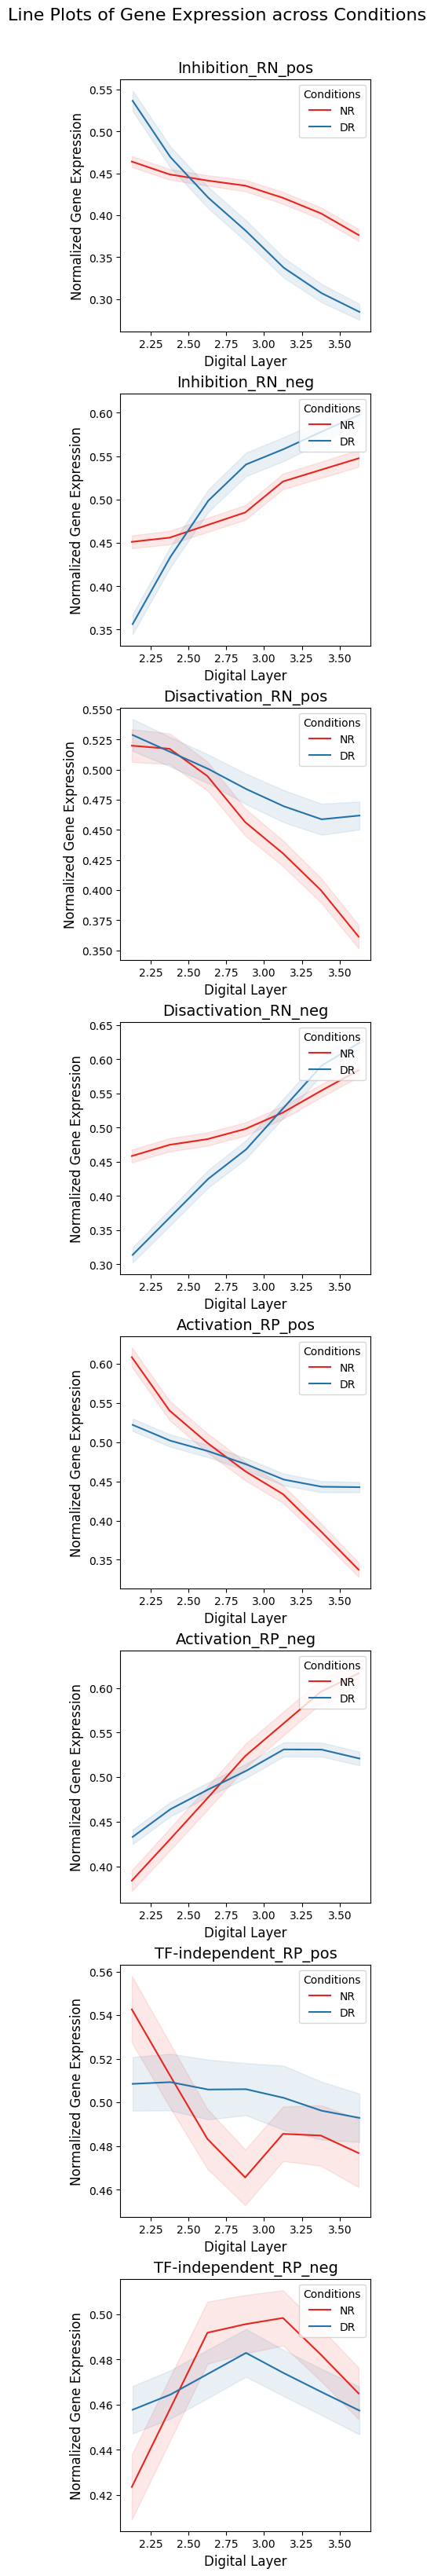

In [107]:
adata = l23_PC1_shifted
adata.X = np.nan_to_num(adata.X)
genesets = new_genesets
slice_categories = ['NR1_2', 'NR2_2', 'DR1_2', 'DR2_2']

# 创建 1列8行的图形布局
fig, axs = plt.subplots(8, 1, figsize=(4, 4 * len(genesets)), constrained_layout=True)

# 为每个 geneset 绘制一个折线图
for row_idx, (geneset_name, geneset) in enumerate(genesets.items()):
    ax = axs[row_idx]  # 获取子图

    if not geneset:
        ax.axis("off")
        continue

    slice_g_values = {}
    slice_gmin_gmax = {}
    slice_vmin_vmax = {}
    vmax_vmin_diffs = {}

    # Step 1: 计算每个 slice 的 g 值并缩放
    for slice_category in slice_categories:
        slice_data = adata[adata.obs['slice'] == slice_category]
        if slice_data.n_obs > 0:
            g = slice_data[:, geneset].X.mean(axis=1).flatten()
            vmin, vmax = np.percentile(g, 5), np.percentile(g, 95)
            g_clipped = np.clip(g, vmin, vmax)
            g_min, g_max = np.min(g_clipped), np.max(g_clipped)
            g_norm = (g_clipped - g_min) / (g_max - g_min)
            slice_g_values[slice_category] = (g_norm, slice_data.obs['digital_layer'])
            slice_gmin_gmax[slice_category] = (g_min, g_max)
            slice_vmin_vmax[slice_category] = (vmin, vmax)
            vmax_vmin_diffs[slice_category] = vmax - vmin

    # Step 2: 选择基准 slice（vmax - vmin 最大的 slice）
    base_slice = max(vmax_vmin_diffs, key=vmax_vmin_diffs.get)
    base_gmin, base_gmax = slice_gmin_gmax[base_slice]

    # Step 3: 调整其他 slice 的 g 值
    adjusted_g_values = {}
    for slice_category in slice_categories:
        g_norm, x = slice_g_values.get(slice_category, (None, None))
        g_min, g_max = slice_gmin_gmax.get(slice_category, (None, None))
        if g_norm is not None:
            # 使用基准 slice 的缩放公式调整 g 值
            g_adjusted = 0.5 + (g_norm - 0.5) * (g_max - g_min) / (base_gmax - base_gmin)
            adjusted_g_values[slice_category] = (g_adjusted, x)

    # Step 4: 合并 NR 和 DR 数据
    nr_g_values = []
    nr_x_values = []
    dr_g_values = []
    dr_x_values = []

    for slice_category in ['NR1_2', 'NR2_2']:
        if slice_category in adjusted_g_values:
            g, x = adjusted_g_values[slice_category]
            nr_g_values.append(g)
            nr_x_values.append(x)

    for slice_category in ['DR1_2', 'DR2_2']:
        if slice_category in adjusted_g_values:
            g, x = adjusted_g_values[slice_category]
            dr_g_values.append(g)
            dr_x_values.append(x)

    if nr_g_values:
        nr_g_values = np.concatenate(nr_g_values)
        nr_x_values = np.concatenate(nr_x_values)

    if dr_g_values:
        dr_g_values = np.concatenate(dr_g_values)
        dr_x_values = np.concatenate(dr_x_values)

    smooth_frac = 0.66  # 越大曲线越平滑

    NR_color = '#E7241D'
    DR_color = '#2372A9'    

    # Step 5: 绘制综合后的折线图
    for g_values, x_values, color, label in zip(
        [nr_g_values, dr_g_values],
        [nr_x_values, dr_x_values],
        [NR_color, DR_color],
        ['NR', 'DR']
    ):
        if g_values.size > 0:
            bins = np.arange(min(x_values), max(x_values), 0.25)
            bin_centers = 0.5 * (bins[1:] + bins[:-1])

            # 计算每个 bin 的均值和标准差
            binned_means = [np.mean(g_values[(x_values >= bins[i]) & (x_values < bins[i + 1])])
                            for i in range(len(bins) - 1)]
            binned_std = [np.std(g_values[(x_values >= bins[i]) & (x_values < bins[i + 1])])
                          for i in range(len(bins) - 1)]

            # LOWESS 会返回和 bin_centers 对应长度的平滑值
            means_smooth = lowess(
                       binned_means, 
                       bin_centers, 
                       frac=smooth_frac, 
                       return_sorted=False
             )
            std_smooth = lowess(
                       binned_std, 
                       bin_centers, 
                       frac=smooth_frac, 
                       return_sorted=False
             )

            # 绘制平滑后的曲线
            ax.plot(bin_centers, means_smooth, color=color, label=label)

            # 绘制阴影：用平滑后的标准差 * 0.05
            ax.fill_between(
                 bin_centers,
                 means_smooth - std_smooth * 0.05,
                 means_smooth + std_smooth * 0.05,
                 color=color, alpha=0.1
             )

    # 设置图标题和标签
    ax.set_title(f"{geneset_name}", fontsize=14)
    #ax.set_ylim(0.2, 0.8)
    ax.set_xlabel('Digital Layer', fontsize=12)
    ax.set_ylabel('Normalized Gene Expression', fontsize=12)

    ax.legend(title="Conditions", fontsize=10, loc="upper right")

# 添加总标题
plt.suptitle("Line Plots of Gene Expression across Conditions", fontsize=16, y=1.02)
plt.show()
#output_path = "F:/spatial/V2L/Figure/V2L_l23_TF_adjusted_lineplot.pdf"
#plt.savefig(output_path, format='pdf', bbox_inches='tight')
#plt.close()
#print(f"PDF saved as {output_path}")